# Mercado Livre API - Overview da API a partir de uma query
Esse notebook apresenta diferentes métricas que se pode obter ao realizar uma query à API do Mercado Libre. 

(No momento, experimentando com diferentes visualizações. Ao finalizar uma versão, a descrição dos passos será completada de acordo).

## Como usar

1. No menu superior: `Cell > Run All`
2. Digitar busca desejada no campo de texto e pressionar *Enter*
3. Aguardar alguns instantes até execução ser completada ("(Busy)" irá desaparecer do título da aba no browser)
4. Rolar para baixo e analisar os gráficos e tabelas

Para uma nova consulta, recomeçar do item 1. 

Obs.: caso a execução apresentar erros, clicar em `Kernel > Restart & Run All` no menu superior.

## Table of contents
- Resumo em lista dos itens com maior faturamento
- Faturamento por itens
- Visualização de quantidades vendidas, preço e estoque
- Análise por local do anúncio (cidade e estado)
- Análise por vendedores (faturamento relativo ao total)
- Histograma de itens adicionados no tempo (recenticidade das ofertas)
- Resumo em lista dos itens mais recentes
- Evolução das visitas aos itens com maior faturamento
- Evolução das visitas aos itens mais vendidos
- Evolução das visitas aos itens mais recentes

## Outputs
Ao final de cada execução, as tabelas de dados são salvas em um arquivo Excel com nome da *query* e data e hora de execução.


## Configurações
Pode-se ajustar o comportamento da análise alterando os valores dos *parâmetros de entrada*.

## Imports e configurações gerais

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import requests
import pandas as pd

from pandas import Series, DataFrame

from IPython.core.display import Image, display

# Charts styling
#plt.style.use('fivethirtyeight')
#plt.style.use('bmh')
plt.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8 # increases figure size
matplotlib.rcParams.update({'font.size': 14}) # increases chart font size
rcParams['font.family'] = 'Arial Narrow'

In [2]:
# style to enhance df viz, from https://github.com/brandon-rhodes/pycon-pandas-tutorial
from IPython.core.display import HTML
css = open('style-table.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Parâmetros de entrada

In [3]:
# Sets input parameters 
DAYS_AGO = 365 # days to look back in visits history
ITEMS_TO_QUERY = 200 # number of itens requested per query (max. permitted by ML is 200)
TOTAL_ITEMS_TO_QUERY = 500 # max. number of results to be downloaded ("None" to make it limitless)
ITEMS_TO_PLOT = 10 # list of "ITEMS_TO_PLOT" top sold items; e.g. if 10, visits from top 10 sold itens will be plotted

## Busca de itens a partir de uma query definida pelo usuário

- Gets para concatenar resultados de buscas
- Corte de itens pelo limite *TOTAL_ITEMS_TO_QUERY*

In [4]:
query = input('Qual a busca desejada? ')

offset = 0
received_itens = 0
results = []

payload = {'q': str(query), 'limit': str(1), 'offset': str(offset)}

url = 'https://api.mercadolibre.com/sites/MLB/search'#?q=' + query +'&limit=' + str(ITEMS_TO_QUERY)
print('Buscando por "' + query + '"')
data = requests.get(url, params=payload).json()

limit_itens = 0
total_itens = data['paging']['total']

print(str(total_itens) + ' resultados encontrados no ML.')

results = data['results'] # saves content from json in variable
df = DataFrame(results) # converts to a pandas df

# simple check for value sanity
if (TOTAL_ITEMS_TO_QUERY == None) or (TOTAL_ITEMS_TO_QUERY > total_itens):
    limit_itens = total_itens
else:
    limit_itens = TOTAL_ITEMS_TO_QUERY
    
print(str(limit_itens) + ' itens sendo transferidos. Aguarde...')

payload['limit']  = str(ITEMS_TO_QUERY) # sets limit

# makes requests querying 200 itens each time until gets all results
while len(df) < limit_itens:
    #print(offset)
    payload['offset'] = str(offset) # updates offset
    data = requests.get(url, params=payload).json()
    results = data['results'] # saves content from json in variable
    df.reset_index(drop=True)
    df = pd.concat([df, DataFrame(results)], axis=0) # concatenates new results to df
    offset = limit_itens - len(df) # updates offset
    progress = int((len(df)/limit_itens)*100) # calculates % of retrieved items
    progress = 100 if progress > 100 else progress
    print(str(progress) + '%')

#print(str(len(df)) + ' itens encontrados.')

Qual a busca desejada? moleskine
Buscando por "moleskine"
486 resultados encontrados no ML.
486 itens sendo transferidos. Aguarde...
41%
82%
100%


In [5]:
# selects a subset of columns, sorts by sold_quantity and fixes index

df = df[['id', 'title', 'price', 'sold_quantity', 'available_quantity', 'permalink', 'thumbnail', 'seller_address', 'seller', 'stop_time']]
df = df.sort_values('sold_quantity', ascending=False) # sorts df by most important column (to be defined, e.g. sold_quantity)
ids = df.id.values[0:ITEMS_TO_PLOT] # gets top sold items ML ids in a list
df = df.set_index('id') # sets index to id

df.head()

,title,price,sold_quantity,available_quantity,permalink,thumbnail,seller_address,seller,stop_time
id,,,,,,,,,
MLB701711029,Caderno Capa Dura Preto Em Couro Sintético. Es...,15.50,347,153,http://produto.mercadolivre.com.br/MLB-7017110...,http://mlb-s2-p.mlstatic.com/474911-MLB2067046...,"{'longitude': -34.8378403, 'state': {'id': 'BR...","{'car_dealer': False, 'tags': [], 'real_estate...",2035-09-13T19:32:21.000Z
MLB743150505,Caderneta Tipo Moleskine Colorida - 1 Unidade,7.08,335,9664,http://produto.mercadolivre.com.br/MLB-7431505...,http://mlb-s2-p.mlstatic.com/250611-MLB2059433...,"{'longitude': -46.7404454, 'state': {'id': 'BR...","{'car_dealer': False, 'tags': [], 'real_estate...",2036-02-14T17:26:07.000Z
MLB743150505,Caderneta Tipo Moleskine Colorida - 1 Unidade,7.08,335,9664,http://produto.mercadolivre.com.br/MLB-7431505...,http://mlb-s2-p.mlstatic.com/250611-MLB2059433...,"{'longitude': -46.7404454, 'state': {'id': 'BR...","{'car_dealer': False, 'tags': [], 'real_estate...",2036-02-14T17:26:07.000Z
MLB762351285,"Caderno Tipo Moleskine, 128x210mm, Sem Pautas,...",19.80,80,1,http://produto.mercadolivre.com.br/MLB-7623512...,http://mlb-s2-p.mlstatic.com/732021-MLB2069971...,"{'longitude': -50.88733, 'state': {'id': 'BR-S...","{'car_dealer': False, 'tags': [], 'real_estate...",2036-05-01T12:26:39.000Z
MLB685047460,Caderno Moleskine Original S Pauta Bolso Azul ...,56.99,48,6,http://produto.mercadolivre.com.br/MLB-6850474...,http://mlb-s2-p.mlstatic.com/17385-MLB20137290...,"{'longitude': -46.7156855, 'state': {'id': 'BR...","{'car_dealer': False, 'tags': [], 'real_estate...",2035-07-26T16:34:47.000Z


## Operações básicas para adicionar colunas e limpar dados
E.g. calcular faturamento, remover duplicatas.

In [6]:
# sorts items by sold quantity and deletes duplicates with less sales (assuming they'd be 0)
df = df.sort_values(by='sold_quantity', ascending=False)
df = df.drop_duplicates(subset=['title'], keep='first')

# calculates total sold quantity
total_sold_quantity = df['sold_quantity'].sum()

# adds revenue column by an operation with sold_quantity and price
df['revenue'] = df['sold_quantity'] * df['price']
total_revenue = df['revenue'].sum()

# fixes 'stop_time' to proper date format
df['stop_time'] = pd.to_datetime(df['stop_time'])

# calculates start time and days ago
start_times = []
days_ago = []

today = dt.datetime.today()

# iterates over df to calculate 'start_time' subtracting 20 years from the 'stop_time' (value of 20 is default for ML's data)
for index, row in df.iterrows():
    stop_time = df.loc[index, 'stop_time']
    #df['start_time'][index] = date.replace(year = date.year - 20)
    start = stop_time
    start = start.replace(year = start.year - 20)
    ago = (today - start).days

    days_ago.append(ago)
    start_times.append(start)
    #print(str(start) + ' ' + str(stop_time))

df['start_time'] = start_times
df['days_ago'] = days_ago

#df
df.head()

,title,price,sold_quantity,available_quantity,permalink,thumbnail,seller_address,seller,stop_time,revenue,start_time,days_ago
id,,,,,,,,,,,,
MLB701711029,Caderno Capa Dura Preto Em Couro Sintético. Es...,15.50,347,153,http://produto.mercadolivre.com.br/MLB-7017110...,http://mlb-s2-p.mlstatic.com/474911-MLB2067046...,"{'longitude': -34.8378403, 'state': {'id': 'BR...","{'car_dealer': False, 'tags': [], 'real_estate...",2035-09-13 19:32:21,5378.50,2015-09-13 19:32:21,426
MLB743150505,Caderneta Tipo Moleskine Colorida - 1 Unidade,7.08,335,9664,http://produto.mercadolivre.com.br/MLB-7431505...,http://mlb-s2-p.mlstatic.com/250611-MLB2059433...,"{'longitude': -46.7404454, 'state': {'id': 'BR...","{'car_dealer': False, 'tags': [], 'real_estate...",2036-02-14 17:26:07,2371.80,2016-02-14 17:26:07,272
MLB762351285,"Caderno Tipo Moleskine, 128x210mm, Sem Pautas,...",19.80,80,1,http://produto.mercadolivre.com.br/MLB-7623512...,http://mlb-s2-p.mlstatic.com/732021-MLB2069971...,"{'longitude': -50.88733, 'state': {'id': 'BR-S...","{'car_dealer': False, 'tags': [], 'real_estate...",2036-05-01 12:26:39,1584.00,2016-05-01 12:26:39,195
MLB685047460,Caderno Moleskine Original S Pauta Bolso Azul ...,56.99,48,6,http://produto.mercadolivre.com.br/MLB-6850474...,http://mlb-s2-p.mlstatic.com/17385-MLB20137290...,"{'longitude': -46.7156855, 'state': {'id': 'BR...","{'car_dealer': False, 'tags': [], 'real_estate...",2035-07-26 16:34:47,2735.52,2015-07-26 16:34:47,475
MLB687908712,"Caderneta Pequena, Tipo Moleskine,10 X 6.5 Cm",6.00,44,6,http://produto.mercadolivre.com.br/MLB-6879087...,http://mlb-s1-p.mlstatic.com/528601-MLB2037236...,"{'longitude': -46.6139735, 'state': {'id': 'BR...","{'car_dealer': False, 'tags': [], 'real_estate...",2035-08-02 19:53:25,264.00,2015-08-02 19:53:25,468


In [7]:
df.describe()

,price,sold_quantity,available_quantity,revenue,days_ago
count,446.000000,446.000000,446.000000,446.000000,446.000000
mean,109.895650,4.717489,373.549327,267.594664,310.672646
std,138.467366,24.020048,1852.547848,688.535183,594.029591
min,6.000000,0.000000,1.000000,0.000000,7.000000
25%,35.587500,0.000000,2.000000,0.000000,113.000000
50%,89.990000,0.000000,5.000000,0.000000,272.000000
75%,139.900000,2.000000,19.000000,154.275000,430.750000
max,2030.660000,347.000000,9999.000000,5596.000000,7298.000000


## Lista de itens com maior faturamento

Os 10 itens com maior faturamento: 



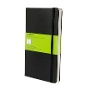

MLB685028677 - Caderno Moleskine Original Sem Pauta Capa Dura G 1146
http://produto.mercadolivre.com.br/MLB-685028677-caderno-moleskine-original-sem-pauta-capa-dura-g-1146-_JM
40 unidades vendidas.
Faturamento de R$ 5596.0.
Preço unitário atual: R$ 139.9.
Adicionado há 475 dias.



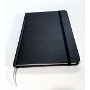

MLB701711029 - Caderno Capa Dura Preto Em Couro Sintético. Estilo Moleskine
http://produto.mercadolivre.com.br/MLB-701711029-caderno-capa-dura-preto-em-couro-sintetico-estilo-moleskine-_JM
347 unidades vendidas.
Faturamento de R$ 5378.5.
Preço unitário atual: R$ 15.5.
Adicionado há 426 dias.



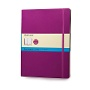

MLB703531354 - Caderno Moleskine Original Pontilhado Gg Purple Flex 3807
http://produto.mercadolivre.com.br/MLB-703531354-caderno-moleskine-original-pontilhado-gg-purple-flex-3807-_JM
25 unidades vendidas.
Faturamento de R$ 4247.5.
Preço unitário atual: R$ 169.9.
Adicionado há 431 dias.



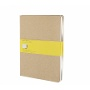

MLB679300100 - Caderno Moleskine Cahier Extra G Kraft Quadriculado 5052 C/3
http://produto.mercadolivre.com.br/MLB-679300100-caderno-moleskine-cahier-extra-g-kraft-quadriculado-5052-c3-_JM
30 unidades vendidas.
Faturamento de R$ 4197.0.
Preço unitário atual: R$ 139.9.
Adicionado há 490 dias.



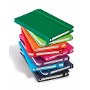

MLB743937765 - Caderneta Tipo Moleskine Colorida - 50 Unidades
http://produto.mercadolivre.com.br/MLB-743937765-caderneta-tipo-moleskine-colorida-50-unidades-_JM
12 unidades vendidas.
Faturamento de R$ 3744.0.
Preço unitário atual: R$ 312.0.
Adicionado há 268 dias.



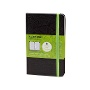

MLB684386756 - Caderno Moleskine Origin Evernote Ruled Smart Notebook Bolso
http://produto.mercadolivre.com.br/MLB-684386756-caderno-moleskine-origin-evernote-ruled-smart-notebook-bolso-_JM
17 unidades vendidas.
Faturamento de R$ 3638.0.
Preço unitário atual: R$ 214.0.
Adicionado há 421 dias.



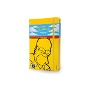

MLB698157908 - Caderno Moleskine Original The Simpsons Pautado G - 4286
http://produto.mercadolivre.com.br/MLB-698157908-caderno-moleskine-original-the-simpsons-pautado-g-4286-_JM
20 unidades vendidas.
Faturamento de R$ 3598.0.
Preço unitário atual: R$ 179.9.
Adicionado há 443 dias.



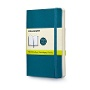

MLB685047460 - Caderno Moleskine Original S Pauta Bolso Azul Capa Flex 3593
http://produto.mercadolivre.com.br/MLB-685047460-caderno-moleskine-original-s-pauta-bolso-azul-capa-flex-3593-_JM
48 unidades vendidas.
Faturamento de R$ 2735.52.
Preço unitário atual: R$ 56.99.
Adicionado há 475 dias.



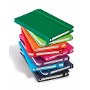

MLB743145591 - Caderneta Tipo Moleskine Colorida - 20 Unidades
http://produto.mercadolivre.com.br/MLB-743145591-caderneta-tipo-moleskine-colorida-20-unidades-_JM
19 unidades vendidas.
Faturamento de R$ 2508.0.
Preço unitário atual: R$ 132.0.
Adicionado há 272 dias.



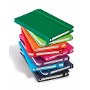

MLB743150505 - Caderneta Tipo Moleskine Colorida - 1 Unidade
http://produto.mercadolivre.com.br/MLB-743150505-caderneta-tipo-moleskine-colorida-1-unidade-_JM
335 unidades vendidas.
Faturamento de R$ 2371.8.
Preço unitário atual: R$ 7.08.
Adicionado há 272 dias.



In [8]:
# prints URLs from itens sorting by revenue

df = df.sort_values('revenue', ascending=False)

print('Os ' + str(ITEMS_TO_PLOT) + ' itens com maior faturamento:', '\n')
for index, row in df.head(ITEMS_TO_PLOT).iterrows():
    display(Image(df.loc[index, 'thumbnail']))
    print(index + ' - ' + df.loc[index, 'title']) # uses loc taking advantage of indexing by id made previously
    print(df.loc[index, 'permalink'])
    print(str(df.loc[index, 'sold_quantity']) + ' unidades vendidas.')
    print('Faturamento de R$ ' + str(df.loc[index, 'revenue']) + '.')
    print('Preço unitário atual: R$ ' + str(df.loc[index, 'price']) + '.')
    print('Adicionado há ' + str(df.loc[index, 'days_ago']) + ' dias.')
    print()

## Faturamento por item

O faturamento total ("moleskine") = R$ 119347.22


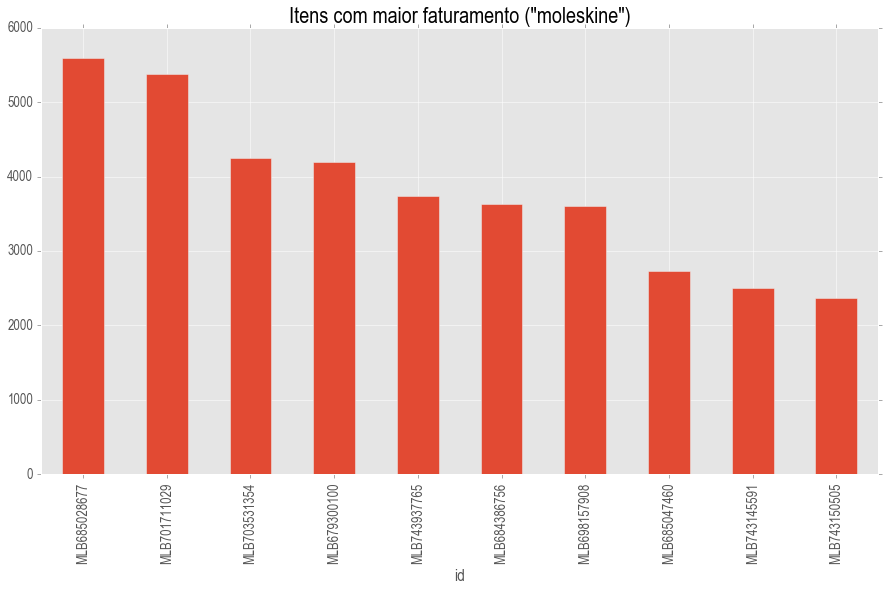

In [9]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))
df['revenue'].sort_values(ascending=False).head(ITEMS_TO_PLOT).plot(kind='bar')
plt.title('Itens com maior faturamento ("' + query + '")', fontsize=22)

## Quantidade vendida e preços

Total de unidades vendidas ("moleskine") = 2104


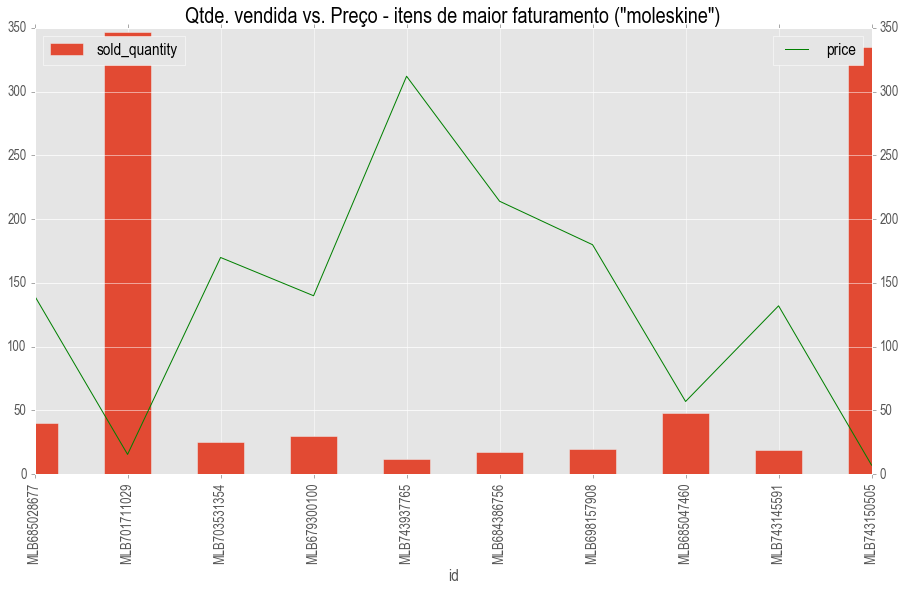

In [10]:
# sold quantity vs. unit price

print('Total de unidades vendidas ("' + query + '") = ' + str(total_sold_quantity))

# procedure to handle secondary Y axis
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()

y0 = df.head(ITEMS_TO_PLOT).sold_quantity.plot(kind='bar', ax=ax0)#, label='Itens vendidos')
y1 = df.head(ITEMS_TO_PLOT).price.plot(secondary_y=True, style='g', ax=ax1)#, label='Preço unitário')
y0.legend(loc=2) # bar legend to the left
y1.legend(loc=0) # line legend to the right

plt.title('Qtde. vendida vs. Preço - itens de maior faturamento ("' + query + '")', fontsize=22)
plt.show()
plt.close()

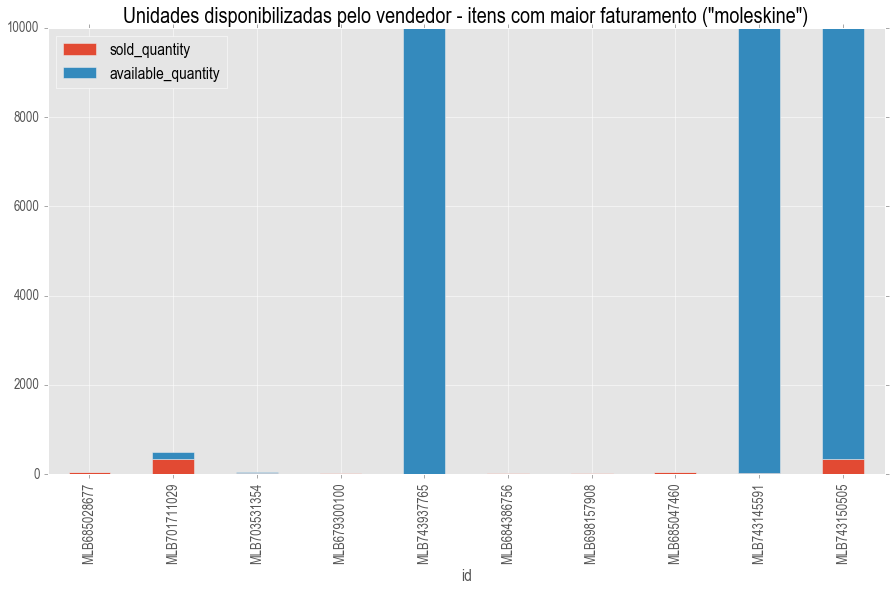

In [11]:
# total amount of each item (sold + stock)

df[['sold_quantity', 'available_quantity']].head(ITEMS_TO_PLOT).plot(kind='bar', stacked=True)
plt.title('Unidades disponibilizadas pelo vendedor - itens com maior faturamento ("' + query + '")', fontsize=22)

## Análise por cidade e estado (qtde. de anúncios e faturamento)

In [12]:
# location and stuff...

df2 = df # creates copy to play with

# extracting info from json/dict objects in cells

cities = [] # empty list to hold city names
states = [] # empty list to hold state names
sellers =[] # empty list to hold sellers ids

for index, row in df2.iterrows():
    cities.append(row['seller_address']['city']['name'])    
    states.append(row['seller_address']['state']['name'])    
    sellers.append(row['seller']['id'])    

df2['city'] = cities
df2['state'] = states
df2['seller_id'] = sellers
df2.head()

,title,price,sold_quantity,available_quantity,permalink,thumbnail,seller_address,seller,stop_time,revenue,start_time,days_ago,city,state,seller_id
id,,,,,,,,,,,,,,,
MLB685028677,Caderno Moleskine Original Sem Pauta Capa Dura...,139.9,40,17,http://produto.mercadolivre.com.br/MLB-6850286...,http://mlb-s2-p.mlstatic.com/15741-MLB20107713...,"{'longitude': -46.7156855, 'state': {'id': 'BR...","{'car_dealer': False, 'tags': [], 'real_estate...",2035-07-26 15:52:04,5596.0,2015-07-26 15:52:04,475,São Paulo,São Paulo,3253841
MLB701711029,Caderno Capa Dura Preto Em Couro Sintético. Es...,15.5,347,153,http://produto.mercadolivre.com.br/MLB-7017110...,http://mlb-s2-p.mlstatic.com/474911-MLB2067046...,"{'longitude': -34.8378403, 'state': {'id': 'BR...","{'car_dealer': False, 'tags': [], 'real_estate...",2035-09-13 19:32:21,5378.5,2015-09-13 19:32:21,426,Olinda,Pernambuco,69846945
MLB703531354,Caderno Moleskine Original Pontilhado Gg Purpl...,169.9,25,14,http://produto.mercadolivre.com.br/MLB-7035313...,http://mlb-s1-p.mlstatic.com/17417-MLB20137256...,"{'longitude': -46.7156855, 'state': {'id': 'BR...","{'car_dealer': False, 'tags': [], 'real_estate...",2035-09-09 00:13:43,4247.5,2015-09-09 00:13:43,431,São Paulo,São Paulo,3253841
MLB679300100,Caderno Moleskine Cahier Extra G Kraft Quadric...,139.9,30,4,http://produto.mercadolivre.com.br/MLB-6793001...,http://mlb-s2-p.mlstatic.com/989001-MLB2026480...,"{'longitude': -46.7156855, 'state': {'id': 'BR...","{'car_dealer': False, 'tags': [], 'real_estate...",2035-07-11 19:48:24,4197.0,2015-07-11 19:48:24,490,São Paulo,São Paulo,3253841
MLB743937765,Caderneta Tipo Moleskine Colorida - 50 Unidades,312.0,12,9987,http://produto.mercadolivre.com.br/MLB-7439377...,http://mlb-s2-p.mlstatic.com/250611-MLB2059433...,"{'longitude': -46.7404454, 'state': {'id': 'BR...","{'car_dealer': False, 'tags': [], 'real_estate...",2036-02-18 17:49:44,3744.0,2016-02-18 17:49:44,268,São Paulo,São Paulo,177494870


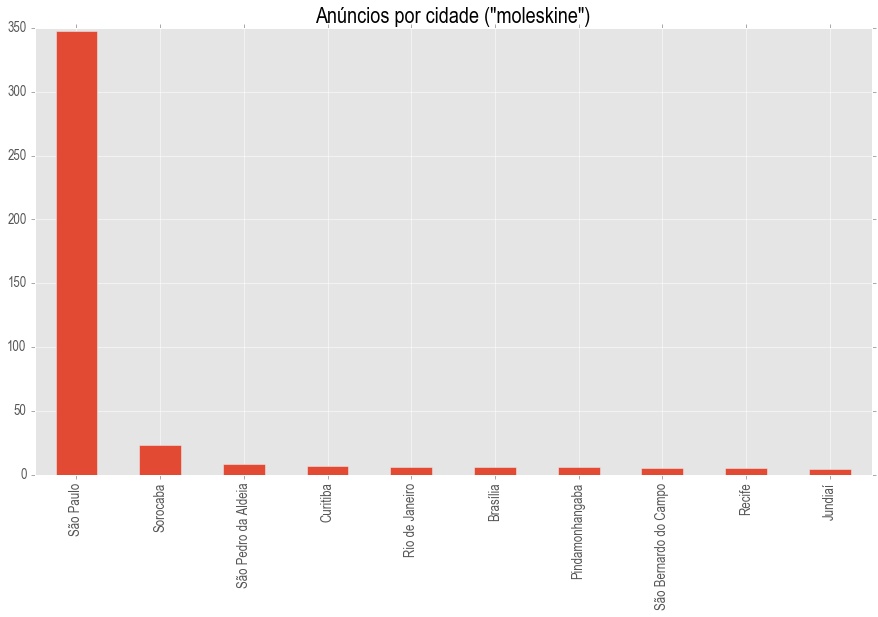

In [13]:
# plots itens by cities

df2.city.value_counts().head(10).plot(kind='bar')
plt.title('Anúncios por cidade ("' + query + '")', fontsize=22)

O faturamento total ("moleskine") = R$ 119347.22


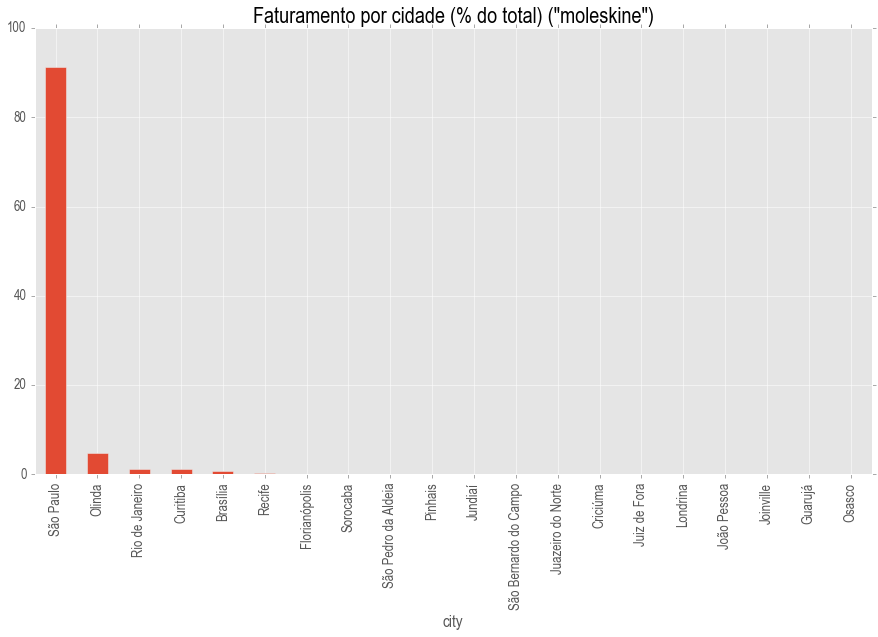

In [14]:
# revenue per city
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

revenue_share_by_city = (df2.groupby('city').sum().revenue / total_revenue) * 100 # aggregates data by city, sums by revenue and gets proportion from total
revenue_share_by_city.sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Faturamento por cidade (% do total) ("' + query + '")', fontsize=22)

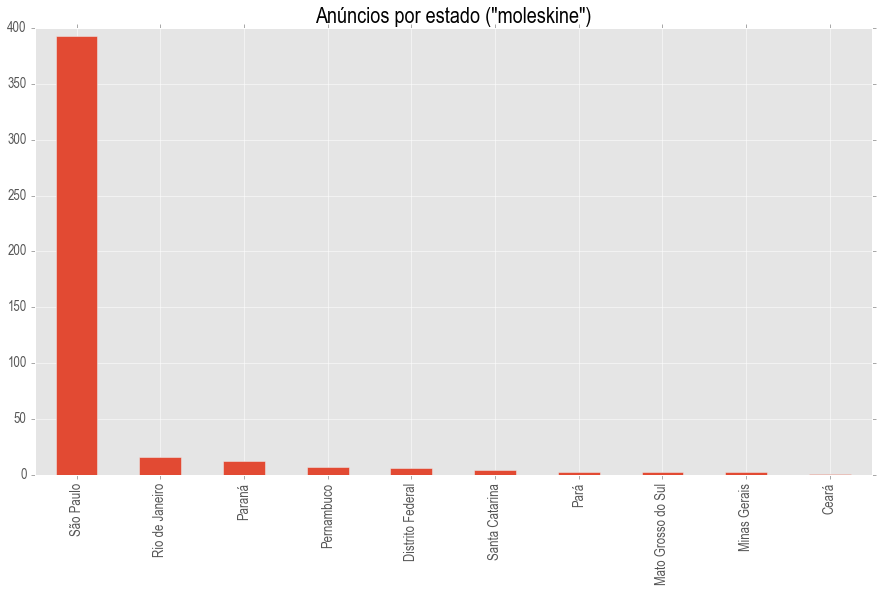

In [15]:
# plots itens by states
df2.state.value_counts().head(10).plot(kind='bar')
plt.title('Anúncios por estado ("' + query + '")', fontsize=22)

O faturamento total ("moleskine") = R$ 119347.22


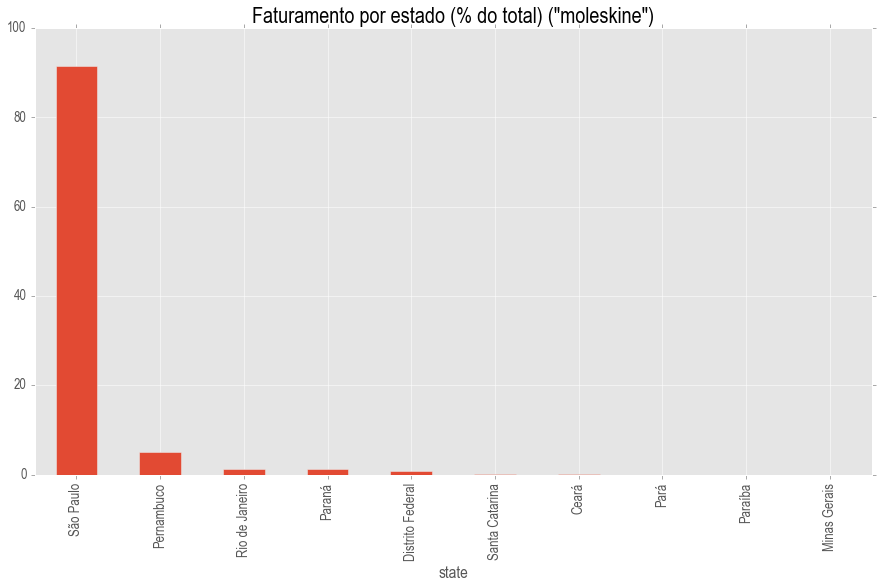

In [16]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

revenue_share_by_state = (df2.groupby('state').sum().revenue / total_revenue) * 100
revenue_share_by_state.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Faturamento por estado (% do total) ("' + query + '")', fontsize=22)

## Análise por vendedores

In [17]:
sellers_df = df2.groupby('seller_id').sum() # aggregates by sellers id, summing up the columns
sellers_df.price = df2.groupby('seller_id').mean().price # substitutes sum of prices by mean price by seller
sellers_df = sellers_df.rename(columns={'price': 'average_price'})
sellers_df.sort_values('revenue', ascending=False).head()

,average_price,sold_quantity,available_quantity,revenue,days_ago
seller_id,,,,,
3253841,115.702009,844,2353,87331.71,60517
177494870,122.683750,548,159436,15221.06,3287
69846945,15.500000,369,231,5719.50,644
171705637,258.602093,102,1728,3755.76,16046
132598684,25.850000,81,21,1599.90,780


O faturamento total ("moleskine") = R$ 119347.22


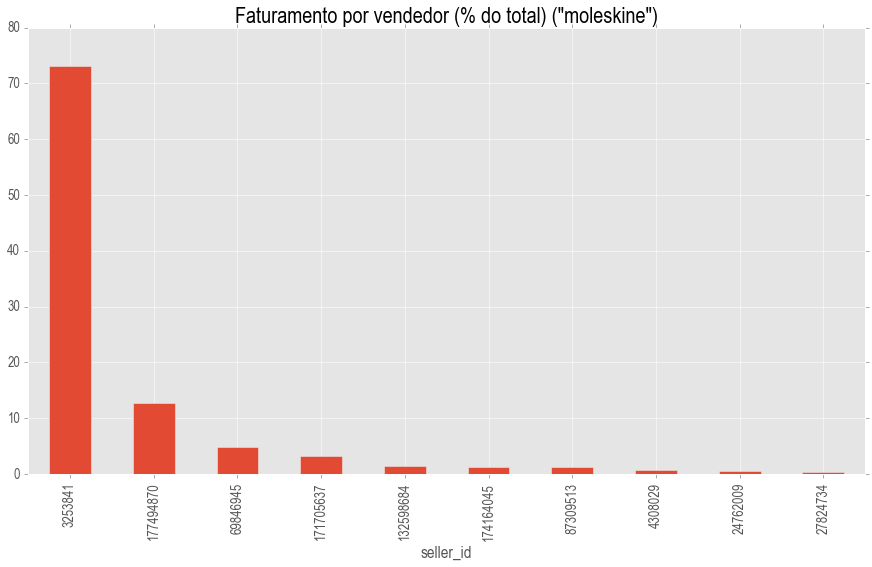

In [18]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

sellers_df = sellers_df.sort_values('revenue', ascending=False)
#sellers_df.revenue.sort_values(ascending=False).head(20).plot(kind='bar')

revenue_share_by_seller = (sellers_df['revenue'] / total_revenue) * 100
revenue_share_by_seller.head(10).plot(kind='bar')
plt.title('Faturamento por vendedor (% do total) ("' + query + '")', fontsize=22)
#sellers_df.head()

### Vendedor e itens como índices
Verificar como operar e se é útil de alguma forma...

In [19]:
# groups sellers and items, and then ...?
s = df2.reset_index()
s = s.groupby(['seller_id', 'id', 'permalink']).sum() # aggregates data by id and permalink to "save" them from being hidden

# sets id and permalink to be data in df
s = s.reset_index('id')
s = s.reset_index('permalink')

#reorder columns to make it readable
s = s[['id', 'sold_quantity', 'price', 'revenue', 'available_quantity', 'permalink']] 

s.head(10)

,id,sold_quantity,price,revenue,available_quantity,permalink
seller_id,,,,,,
3253841,MLB679016299,1,72.9,72.9,5,http://produto.mercadolivre.com.br/MLB-6790162...
3253841,MLB679019370,1,72.9,72.9,5,http://produto.mercadolivre.com.br/MLB-6790193...
3253841,MLB679020850,0,72.9,0.0,44,http://produto.mercadolivre.com.br/MLB-6790208...
3253841,MLB679021292,0,72.9,0.0,7,http://produto.mercadolivre.com.br/MLB-6790212...
3253841,MLB679023519,4,72.9,291.6,49,http://produto.mercadolivre.com.br/MLB-6790235...
3253841,MLB679026351,2,72.9,145.8,12,http://produto.mercadolivre.com.br/MLB-6790263...
3253841,MLB679030349,0,72.9,0.0,15,http://produto.mercadolivre.com.br/MLB-6790303...
3253841,MLB679030440,0,72.9,0.0,15,http://produto.mercadolivre.com.br/MLB-6790304...
3253841,MLB679032019,0,25.0,0.0,4,http://produto.mercadolivre.com.br/MLB-6790320...


## Análise da data de anúncio dos itens (recenticidade)

In [20]:
# plot by days_ago (by date as the following charts is nicer)
#_range = (0, 30)
#df.days_ago.hist(range=_range, bins=30)
#plt.title('Distribuição de itens adicionados nos últimos 30 dias (dias atrás) ("' + query + '")', fontsize=22)

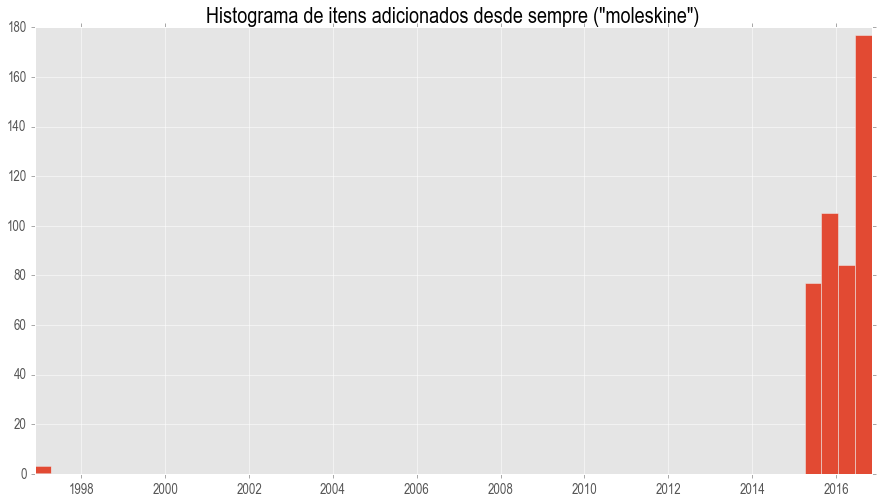

In [21]:
s = df

s.start_time.hist(bins=50)
plt.title('Histograma de itens adicionados desde sempre ("' + query + '")', fontsize=22)

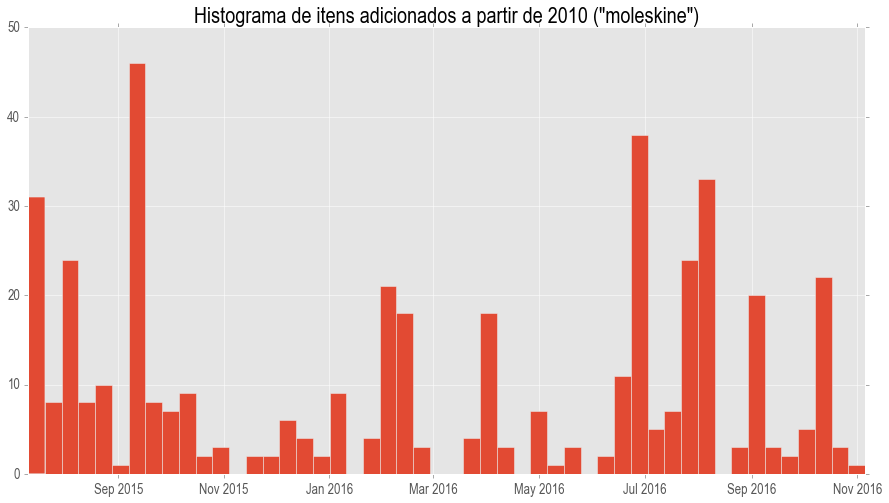

In [22]:
s = df[(df.start_time > '2010-01-01')] # filter dates later than 2010

s.start_time.hist(bins=50)
plt.title('Histograma de itens adicionados a partir de 2010 ("' + query + '")', fontsize=22)

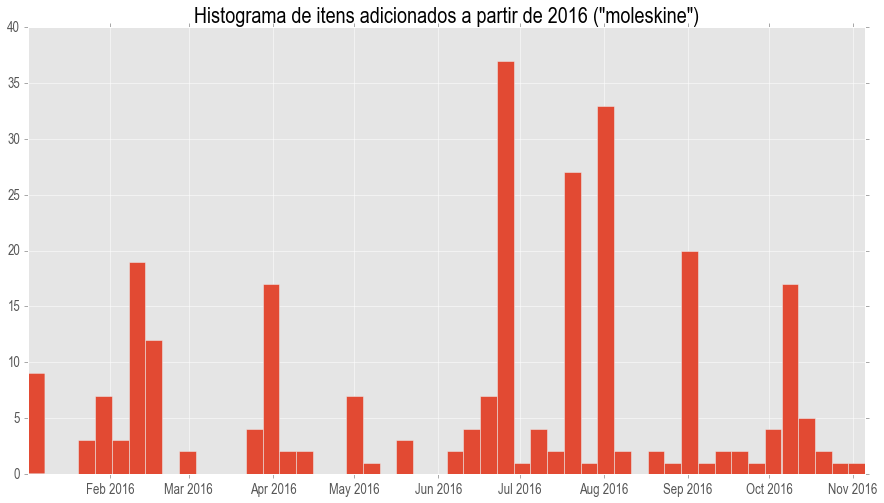

In [23]:
s = df[(df.start_time > '2016-01-01')] # filter dates later than 2016

s.start_time.hist(bins=50)
plt.title('Histograma de itens adicionados a partir de 2016 ("' + query + '")', fontsize=22)

## Lista de itens mais recentes

Os 10 itens mais recentes: 



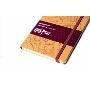

MLB811329775 - Caderno Moleskine Grande Edicao Limitada Harry Potter Kraft
http://produto.mercadolivre.com.br/MLB-811329775-caderno-moleskine-grande-edicao-limitada-harry-potter-kraft-_JM
Adicionado há 7 dias.
Preço unitário atual: R$ 179.9.
0 unidade(s) já vendida(s).



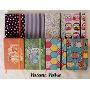

MLB808144242 - Caderneta Moleskine Madame Malkin
http://produto.mercadolivre.com.br/MLB-808144242-caderneta-moleskine-madame-malkin-_JM
Adicionado há 19 dias.
Preço unitário atual: R$ 20.0.
0 unidade(s) já vendida(s).



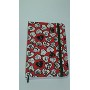

MLB806591011 - Caderno De Desenho/ Sketchbooks 15 Cm / Tipo Moleskine
http://produto.mercadolivre.com.br/MLB-806591011-caderno-de-desenho-sketchbooks-15-cm-tipo-moleskine-_JM
Adicionado há 24 dias.
Preço unitário atual: R$ 12.95.
0 unidade(s) já vendida(s).



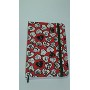

MLB806599024 - Lote De 02 Cadernos/ Sketchbooks 15x10/tipo Moleskine
http://produto.mercadolivre.com.br/MLB-806599024-lote-de-02-cadernos-sketchbooks-15x10tipo-moleskine-_JM
Adicionado há 24 dias.
Preço unitário atual: R$ 19.95.
0 unidade(s) já vendida(s).



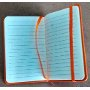

MLB770372744 - Caderneta Tipo Moleskine Bloco Anotações De Bolso Pauta 9x14
http://produto.mercadolivre.com.br/MLB-770372744-caderneta-tipo-moleskine-bloco-anotacoes-de-bolso-pauta-9x14-_JM
Adicionado há 29 dias.
Preço unitário atual: R$ 9.99.
0 unidade(s) já vendida(s).



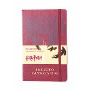

MLB804831285 - Caderno Moleskine Grande Edicao Limitada Harry Potter
http://produto.mercadolivre.com.br/MLB-804831285-caderno-moleskine-grande-edicao-limitada-harry-potter-_JM
Adicionado há 30 dias.
Preço unitário atual: R$ 179.9.
0 unidade(s) já vendida(s).



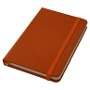

MLB770367103 - Caderneta Tipo Moleskine Bloco Anotações Pauta 12,5x17,5
http://produto.mercadolivre.com.br/MLB-770367103-caderneta-tipo-moleskine-bloco-anotacoes-pauta-125x175-_JM
Adicionado há 30 dias.
Preço unitário atual: R$ 17.9.
0 unidade(s) já vendida(s).



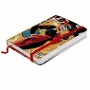

MLB804953037 - Caderneta Estilo Moleskini Harley Quinn  - Dc Comics
http://produto.mercadolivre.com.br/MLB-804953037-caderneta-estilo-moleskini-harley-quinn-dc-comics-_JM
Adicionado há 30 dias.
Preço unitário atual: R$ 20.99.
0 unidade(s) já vendida(s).



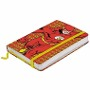

MLB804894114 - Caderneta Estilo Moleskini The Flash  - Dc Comics
http://produto.mercadolivre.com.br/MLB-804894114-caderneta-estilo-moleskini-the-flash-dc-comics-_JM
Adicionado há 30 dias.
Preço unitário atual: R$ 21.99.
0 unidade(s) já vendida(s).



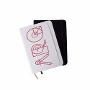

MLB803947846 - Moleskine/caderneta Arquitetura E Urbanismo
http://produto.mercadolivre.com.br/MLB-803947846-moleskinecaderneta-arquitetura-e-urbanismo-_JM
Adicionado há 33 dias.
Preço unitário atual: R$ 12.0.
0 unidade(s) já vendida(s).



In [24]:
print('Os ' + str(ITEMS_TO_PLOT) + ' itens mais recentes:', '\n')

recent_itens_df = df.sort_values('days_ago', ascending=True)

for index, row in recent_itens_df.head(ITEMS_TO_PLOT).iterrows():
    display(Image(df.loc[index, 'thumbnail'])) 
    print(index + ' - ' + df.loc[index, 'title']) # uses loc taking advantage of indexing by id made previously
    print(df.loc[index, 'permalink'])
    print('Adicionado há ' + str(df.loc[index, 'days_ago']) + ' dias.')
    print('Preço unitário atual: R$ ' + str(df.loc[index, 'price']) + '.')
    print(str(df.loc[index, 'sold_quantity']) + ' unidade(s) já vendida(s).')
    print()

    

---
## Request por visitas dos itens filtrados e ordenados

- Itens com maior faturamento
- Itens mais vendidos
- Itens mais recentes

### Função para gerar DataFrame de visitas

In [25]:
def get_visits_df(days, ids):
    
    ids_string = ','.join(ids) # makes comma-separated string from list to use in URL

    url = 'https://api.mercadolibre.com/items/visits/time_window?ids=' + ids_string +'&last=' + str(days) + '&unit=day'
    data = requests.get(url).json()

    visits_df = DataFrame(data[0]['results']) # initialize a df with the first item out of 10 (top ten in ids_string)
    visits_df = visits_df[['date', 'total']] # gets only main columns
    visits_df.columns = ['date', data[0]['item_id']] # renames 'total' to item's ID

    column_headers = [] # list to store item ids used as column headers
    column_headers.append(data[0]['item_id'])

    # iterates over data items to merge all 'total' columns into same df
    for item in data[1:]:
        results = item['results']
        df_temp = DataFrame(results)
        df_temp = df_temp[['date', 'total']]
        df_temp.columns = ['date', item['item_id']]
        column_headers.append(item['item_id'])
        visits_df = pd.merge(visits_df, df_temp, on='date')

    #print(column_headers)
    #visits_df.head()

    # fixes df, parsing 'date' properly and setting as index column
    visits_df['date'] = pd.to_datetime(visits_df['date'])
    visits_df = visits_df.set_index('date')

    #visits_df.head()
    return visits_df

### Visitas aos itens com maior faturamento

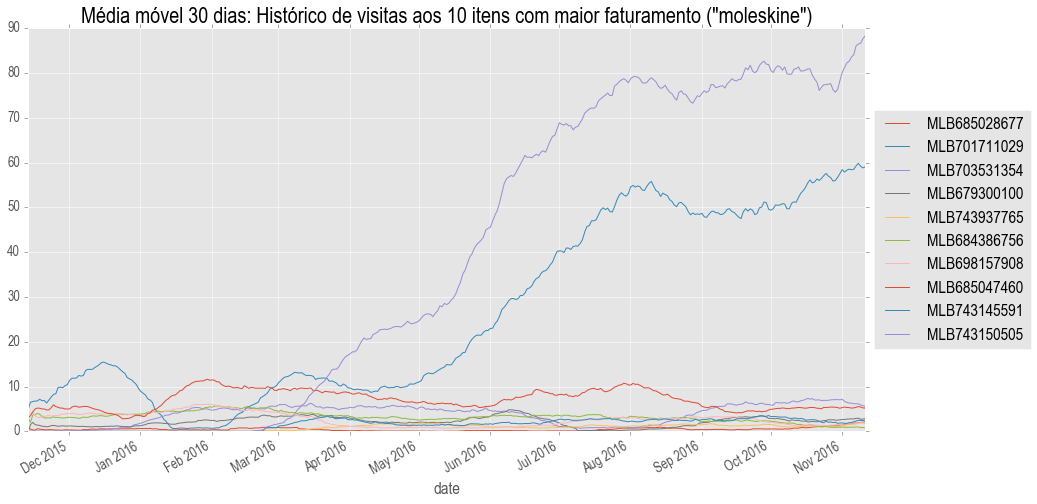

In [26]:
# defines ids from top revenue itens
top_revenue_ids = df.sort_values('revenue', ascending=False).index.values[0:ITEMS_TO_PLOT]

# get df by calling function with top sold ids
visits_df = get_visits_df(DAYS_AGO, top_revenue_ids)

# calculates and plots visits' rolling mean (smoother curves)
days_rolling = 30;
rolling_mean_df = visits_df.rolling(window=days_rolling, min_periods=1).mean() # window is the # of days evaluated in rolling mean
ax = rolling_mean_df.plot();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # moves legend to the right outside
plt.title('Média móvel ' + str(days_rolling) + ' dias: Histórico de visitas aos ' + str(ITEMS_TO_PLOT) + ' itens com maior faturamento ("' + query + '")', fontsize=22)

most_revenue_visits_df = visits_df # saves to a uniquely named df to be exported later

### Visitas aos itens mais vendidos

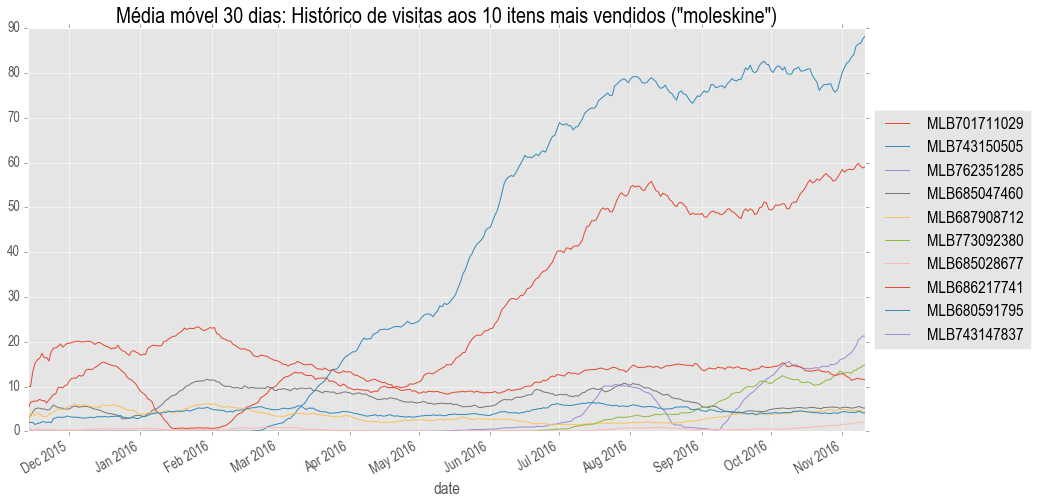

In [27]:
# defines ids from top sold itens
top_sold_ids = df.sort_values('sold_quantity', ascending=False).index.values[0:ITEMS_TO_PLOT]

# get df by calling function with top sold ids
visits_df = get_visits_df(DAYS_AGO, top_sold_ids)

# calculates and plots visits' rolling mean (smoother curves)
days_rolling = 30;
rolling_mean_df = visits_df.rolling(window=days_rolling, min_periods=1).mean() # window is the # of days evaluated in rolling mean
ax = rolling_mean_df.plot();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # moves legend to the right outside
plt.title('Média móvel ' + str(days_rolling) + ' dias: Histórico de visitas aos ' + str(ITEMS_TO_PLOT) + ' itens mais vendidos ("' + query + '")', fontsize=22)

most_sold_visits_df = visits_df # saves to a uniquely named df to be exported later

### Visitas aos itens mais recentes

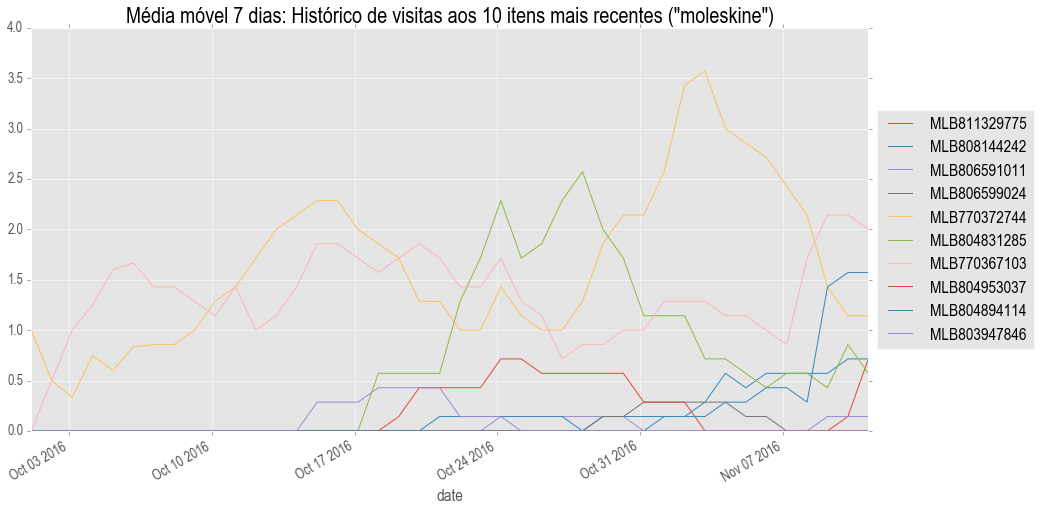

In [28]:
# gets ids from most recent itens
recent_ids = recent_itens_df.index.values[0:ITEMS_TO_PLOT] # gets most recent items ML ids in a list

# get df by calling function with most recent ids
visits_df = get_visits_df(DAYS_AGO, recent_ids)
visits_df = visits_df['2016-10-01':] # filters by some date (e.g. 1st of january, 2016)

# calculates and plots visits' rolling mean (smoother curves)
days_rolling = 7;
rolling_mean_df = visits_df.rolling(window=days_rolling, min_periods=1).mean() # window is the # of days evaluated in rolling mean
ax = rolling_mean_df.plot();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # moves legend to the right outside
plt.title('Média móvel ' + str(days_rolling) + ' dias: Histórico de visitas aos ' + str(ITEMS_TO_PLOT) + ' itens mais recentes ("' + query + '")', fontsize=22)

most_recent_visits_df = visits_df # saves to a uniquely named df to be exported later

In [29]:
# normal plot
#plt.figure()
#visits_df.plot(legend=True);
#plt.title('Histórico de visitas aos 10 itens mais vendidos ("' + query + '")', fontsize=22)

# cumulative sum plot
#cumulative_visits_df = visits_df.cumsum() # calculates accumulated values to plot
#plt.figure();
#cumulative_visits_df.plot(legend=True);
#plt.title('Soma acumulada: Histórico de visitas aos 10 itens mais vendidos ("' + query + '")', fontsize=22)

## Exporta dados para Excel
Salva os principais DataFrames em diferentes abas de um arquivo .xlsx e salva na pasta raiz.

In [30]:
# saves main df to Excel format
today_str = today.strftime('%Y-%m-%d_%H%M') # makes string with today's date

writer = pd.ExcelWriter(today_str + '_' + query + '.xlsx')

df.to_excel(writer, 'main_data')
sellers_df.to_excel(writer, 'sellers')
most_revenue_visits_df.to_excel(writer, 'visits-revenue_sold')
most_sold_visits_df.to_excel(writer, 'visits-most_sold')
most_recent_visits_df.to_excel(writer, 'visits-most_recent')

writer.save()
writer.close()

## Todo:
**Features**
- Plot itens by seller location (map?)
- <s>Calculate revenue per seller (extract from seller dict in raw df)</s>
- <s>Understand data aggregated by SELLER, not only by separate items</s>
- Get location of the BUYERS, not only sellers
- Compare seller revenue with its ratings/feedbacks
- <s>Analyse itens by date and recently added itens</s>
- <s>Play around with 'added_days_ago' and 'sold_quantity' = how appealing the product is</s>
- Filter by minimum item price
---
**Code improvement**
- Fix query handling for 0 results
- Fix query handling for null query as input
- Fix documentation/description
- Make dates relative to today's (e.g. instead of '2016', get the year from datetime 'today')
---
**Usability**
- Add an index for jumping to parts (links for navigation)